## Google Search vs. Sonar Pro vs. Bing Search vs. OpenAI Web Search

### Helper functions

In [ ]:
import csv
from datetime import datetime
from serpapi import GoogleSearch
import pytz

local_tz = pytz.timezone("America/Toronto")

def get_serpapi_urls(query, engine, num_results=10):
    params = {
        "engine": engine,
        "q": query,
        # "gl": "ca",
        # "cc": "CA",
        "api_key": SERPAPI_API_KEY,
        "num": num_results
    }
    search = GoogleSearch(params)
    results = search.get_dict()
    organic_results = results.get("organic_results", [])
    urls = []
    for res in organic_results:
        url = res.get("link", None)
        if url:
            urls.append(url)
    return urls

def save_multiple_queries_to_csv(queries_by_category, engine="google", num_results=10, output_filename="serpapi_sources.csv"):
    timestamp = datetime.now(local_tz).strftime("%Y-%m-%d %H:%M:%S")

    with open(output_filename, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(["Query", "Category", "Source", "Source Rank", "Timestamp", "Search Source"])

        for category, query in queries_by_category.items():
            urls = get_serpapi_urls(query, engine=engine, num_results=num_results)
            for rank, url in enumerate(urls, start=1):
                writer.writerow([query, category, url, rank, timestamp, engine.title() + " Search"])

    print(f"✅ All results saved to {output_filename}")


In [ ]:
# get_serpapi_urls('best instant coffee', engine='bing')

In [ ]:
from urllib.parse import urlparse, urlunparse
import pandas as pd
import ast
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

def normalize_url(url):
    try:
        parsed = urlparse(url)
        clean_url = urlunparse((parsed.scheme, parsed.netloc, parsed.path.rstrip("/"), '', '', ''))
        return clean_url.lower()
    except:
        return str(url).lower().strip()

def compare_2_urls_by_category(
    df1, df2,
    url_col1, url_col2,
    plot=False,
    venn_labels=('File 1', 'File 2'),
    summary_labels=('URLs in File1', 'URLs in File2')
):
    import ast
    import pandas as pd
    from matplotlib_venn import venn2
    import matplotlib.pyplot as plt

    def normalize_url(url):
        return url.strip().rstrip("/").lower()

    def extract_urls(cell):
        try:
            urls = ast.literal_eval(cell) if isinstance(cell, str) and cell.startswith("[") else [cell]
            return [normalize_url(u) for u in urls if isinstance(u, str)]
        except Exception:
            return []

    # Normalize category column
    df1["Category"] = df1["Category"].str.lower()
    df2["Category"] = df2["Category"].str.lower()

    # Explode any lists of URLs
    df1["Normalized URL"] = df1[url_col1].apply(extract_urls)
    df1 = df1.explode("Normalized URL")

    df2["Normalized URL"] = df2[url_col2].apply(extract_urls)
    df2 = df2.explode("Normalized URL")

    all_categories = sorted(set(df1["Category"].unique()) | set(df2["Category"].unique()))
    summary = []

    for category in all_categories:
        urls1 = df1[df1["Category"] == category]
        urls2 = df2[df2["Category"] == category]

        set1 = set(urls1["Normalized URL"].dropna().unique())
        set2 = set(urls2["Normalized URL"].dropna().unique())

        common = set1 & set2
        only1 = set1 - set2
        only2 = set2 - set1

        total_unique = len(set1 | set2)
        overlap_rate = len(common) / total_unique if total_unique else 0

        summary.append({
            "Category": category,
            summary_labels[0]: len(set1),
            summary_labels[1]: len(set2),
            "Common URLs": len(common),
            "Common URL List": sorted(common),
            "Overlap Rate %": round(overlap_rate * 100, 2)
        })

        # Print results
        print(f"\n📦 Category: {category}")
        print(f"✅ Common URLs ({len(common)}):")
        for u in sorted(common):
            print("   ", u)

        print(f"\n🔴 Only in {venn_labels[0]} ({len(only1)}):")
        print(
            urls1[urls1["Normalized URL"].isin(only1)]
            [[url_col1]]
            .drop_duplicates(subset=url_col1)
        )

        print(f"\n🔵 Only in {venn_labels[1]} ({len(only2)}):")
        print(
            urls2[urls2["Normalized URL"].isin(only2)]
            [[url_col2]]
            .drop_duplicates(subset=url_col2)
        )

        if plot:
            venn2([set1, set2], set_labels=venn_labels)
            plt.title(f"URL Overlap for {category}")
            plt.show()

    return pd.DataFrame(summary)


### Data Preparation

In [ ]:
queries = {
    "Instant Coffee": "Top recommended Instant Coffee in Canada"
    # "Cat Food": "best cat food",
    # "Dog Food": "best dog food",
    # "Baking Ingredients": "best baking ingredients",
    # "Cat Litter": "best cat litter"
}

save_multiple_queries_to_csv(queries_by_category=queries, engine="google", num_results=20, output_filename="serpapi_google_5_5.csv")
save_multiple_queries_to_csv(queries_by_category=queries, engine="bing", num_results=20, output_filename="serpapi_bing_5_5.csv")
serpapi_google_results = pd.read_csv("serpapi_google_5_5.csv")
serpapi_bing_results = pd.read_csv("serpapi_bing_5_5.csv")

✅ All results saved to serpapi_google_5_5.csv
✅ All results saved to serpapi_bing_5_5.csv


In [ ]:
# serpapi_google_results = pd.read_csv("GoogleSearch_instant_coffee.csv")
# serpapi_bing_results = pd.read_csv("BingSearch_instant_coffee.csv")

In [ ]:
serpapi_google_results['Category'] = 'Instant Coffee'
serpapi_bing_results['Category'] = 'Instant Coffee'

In [ ]:
# SonarPro_data = pd.read_csv("Sonar_Pro_4_16.csv")
# OpenAI_data = pd.read_csv("OpenAI_Web_Search_4_16.csv")

# SonarPro_data = SonarPro_data.rename(columns={"category": "Category"})
# OpenAI_data = OpenAI_data.rename(columns={"category": "Category"})

In [ ]:
OpenAI_data_raw = pd.read_csv("OpenAI_web_search_4_21_processed.csv")
OpenAI_data_raw.head()

,Unnamed: 0,brand,long_title,short_title,description,urls,category,retail,query,timestamp,...,gpt-4o-search-preview_temp0_round123,gpt-4o-search-preview_temp0_round126,gpt-4o-search-preview_temp0_round135,gpt-4o-search-preview_temp0_round138,gpt-4o-search-preview_temp0_round139,Mention Count,Avg Rank (Skip NaN),Avg Rank (Fill 0),Avg Rank (Fill 11),URLs count
0,0,Tim Hortons,"Tim Hortons Medium Roast Instant Coffee, 100% ...",Tim Hortons Medium Roast Instant Coffee,A well-balanced medium roast made with 100% Co...,['https://cornercoffeestore.com/best-instant-c...,Instant Coffee,NaN,Top Ten recommended Instant Coffee in Canada. ...,2025-04-21 15:21,...,NaN,NaN,NaN,NaN,NaN,79,1.00,0.77,3.25,2
1,1,Maxwell House,"Maxwell House Original Roast Instant Coffee, 1...",Maxwell House Original Roast Instant Coffee,A classic medium roast known for its affordabi...,['https://cornercoffeestore.com/best-instant-c...,Instant Coffee,NaN,Top Ten recommended Instant Coffee in Canada. ...,2025-04-21 15:21,...,5.0,2.0,2.0,2.0,2.0,102,2.09,2.09,2.09,2
2,2,Starbucks,Starbucks Via Instant True North Blend Blonde ...,Starbucks Via Instant True North Blend,A mellow blonde roast made from 100% Arabica b...,['https://cornercoffeestore.com/best-instant-c...,Instant Coffee,NaN,Top Ten recommended Instant Coffee in Canada. ...,2025-04-21 15:21,...,NaN,NaN,NaN,NaN,NaN,79,3.00,2.32,4.80,2
3,3,Nescafé,"Nescafé Gold Espresso Instant Coffee, 200g",Nescafé Gold Espresso Instant Coffee,"Made with 100% Arabica beans, this instant cof...",['https://cornercoffeestore.com/best-instant-c...,Instant Coffee,NaN,Top Ten recommended Instant Coffee in Canada. ...,2025-04-21 15:21,...,NaN,NaN,NaN,NaN,NaN,79,4.00,3.10,5.58,2
4,4,Nescafé,"Nescafé Rich Instant Coffee, Dark Roast Coffee...",Nescafé Rich Instant Coffee,A well-priced dark roast supporting sustainabl...,['https://cornercoffeestore.com/best-instant-c...,Instant Coffee,NaN,Top Ten recommended Instant Coffee in Canada. ...,2025-04-21 15:21,...,NaN,NaN,NaN,NaN,NaN,79,5.00,3.87,6.35,2


In [ ]:
# import pandas as pd

# def compute_llm_ranking_summary(input_csv_path, output_csv_path, round_keyword="round"):

#     df = pd.read_csv(input_csv_path)

#     # Obtain ranking columns
#     rank_cols = [col for col in df.columns if round_keyword.lower() in col.lower()]

#     df["Mention Count"] = df[rank_cols].notna().sum(axis=1)
#     df["Avg Rank (Skip NaN)"] = df[rank_cols].mean(axis=1).round(2)
#     df["Avg Rank (Fill 0)"] = df[rank_cols].fillna(0).mean(axis=1).round(2)
#     df["Avg Rank (Fill 11)"] = df[rank_cols].fillna(11).mean(axis=1).round(2)

#     # URLs count
#     if "urls" in df.columns:
#         def count_urls(cell):
#             try:
#                 urls = ast.literal_eval(cell)
#                 return len(urls) if isinstance(urls, list) else 0
#             except:
#                 return 0

#         df["URLs count"] = df["urls"].apply(count_urls)

#     df.to_csv(output_csv_path, index=False)
#     print(f"✅ Summary saved to: {output_csv_path}")

#     return df

# df_summary = compute_llm_ranking_summary(
#     input_csv_path="OpenAI_web_search_4_21.csv",
#     output_csv_path="OpenAI_web_search_4_21_processed.csv"
# )

# OpenAI_data = df_summary[['brand', 'short_title', 'urls', 'category', 'URLs count', 'Mention Count', 'Avg Rank (Skip NaN)', 'Avg Rank (Fill 0)', 'Avg Rank (Fill 11)']]
# OpenAI_data = OpenAI_data.rename(columns={"category": "Category"})
# OpenAI_data.head()

✅ Summary saved to: OpenAI_web_search_4_21_processed.csv


In [ ]:
OpenAI_data = OpenAI_data_raw[['brand', 'short_title', 'urls', 'category', 'URLs count', 'Mention Count', 'Avg Rank (Skip NaN)', 'Avg Rank (Fill 0)', 'Avg Rank (Fill 11)']]
OpenAI_data = OpenAI_data.rename(columns={"category": "Category"})
OpenAI_data.head()

,brand,short_title,urls,Category,URLs count,Mention Count,Avg Rank (Skip NaN),Avg Rank (Fill 0),Avg Rank (Fill 11)
0,Tim Hortons,Tim Hortons Medium Roast Instant Coffee,['https://cornercoffeestore.com/best-instant-c...,Instant Coffee,2,79,1.00,0.77,3.25
1,Maxwell House,Maxwell House Original Roast Instant Coffee,['https://cornercoffeestore.com/best-instant-c...,Instant Coffee,2,102,2.09,2.09,2.09
2,Starbucks,Starbucks Via Instant True North Blend,['https://cornercoffeestore.com/best-instant-c...,Instant Coffee,2,79,3.00,2.32,4.80
3,Nescafé,Nescafé Gold Espresso Instant Coffee,['https://cornercoffeestore.com/best-instant-c...,Instant Coffee,2,79,4.00,3.10,5.58
4,Nescafé,Nescafé Rich Instant Coffee,['https://cornercoffeestore.com/best-instant-c...,Instant Coffee,2,79,5.00,3.87,6.35


### Comparison


📦 Category: instant coffee
✅ Common URLs (3):
    https://cornercoffeestore.com/best-instant-coffees-canada
    https://www.dropmocha.ca/post/savoring-convenience-the-best-instant-coffees-to-buy-in-canada
    https://www.narcity.com/instant-coffee-comparison-canada

🔴 Only in Google Search (16):
                                               Source
1   https://www.reddit.com/r/BuyCanadian/comments/...
2   https://www.andreaference.com/blog/the-best-in...
3   https://www.bonappetit.com/story/best-instant-...
5   https://www.amazon.ca/best-instant-coffee/s?k=...
6   https://www.allrecipes.com/longform/best-insta...
7   https://justuscoffee.com/products/organic-inst...
8   https://www.thekitchn.com/best-instant-coffee-...
9   https://www.businessinsider.com/what-is-the-be...
10  https://www.thespruceeats.com/best-instant-cof...
11  https://www.seriouseats.com/best-instant-coffe...
12  https://www.bestproductscanada.com/instant-coffee
13  https://www.wired.com/gallery/best-instant-cof...


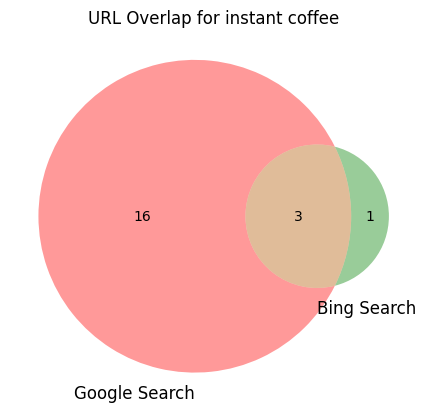

,Category,URLs in Google Search,URLs in Bing Search,Common URLs,Common URL List,Overlap Rate %
0,instant coffee,19,4,3,[https://cornercoffeestore.com/best-instant-co...,15.0


In [ ]:
compare_2_urls_by_category(
    serpapi_google_results,
    serpapi_bing_results,
    url_col1="Source",
    url_col2="Source",
    plot=True,
    venn_labels=('Google Search', 'Bing Search'),
    summary_labels=('URLs in Google Search', 'URLs in Bing Search')
)


📦 Category: instant coffee
✅ Common URLs (2):
    https://cornercoffeestore.com/best-instant-coffees-canada
    https://www.bestproductscanada.com/instant-coffee

🔴 Only in OpenAI Web Search (7):
                                                 urls
0   ['https://cornercoffeestore.com/best-instant-c...
4   ['https://cornercoffeestore.com/best-instant-c...
10  ['https://www.bestproductscanada.com/instant-b...
12  ['https://www.bestproductscanada.com/instant-c...
13  ['https://en.wikipedia.org/wiki/Nabob_%28coffe...
16     ['https://en.wikipedia.org/wiki/Nescaf%C3%A9']
17       ['https://en.wikipedia.org/wiki/Just_Us%21']
18          ['https://en.wikipedia.org/wiki/Folgers']
19  ['https://www.amazon.ca/Best-Sellers-Instant-C...

🔵 Only in Google Search (17):
                                               Source
0   https://www.narcity.com/instant-coffee-compari...
1   https://www.reddit.com/r/BuyCanadian/comments/...
2   https://www.andreaference.com/blog/the-best-in...
3   https://www.

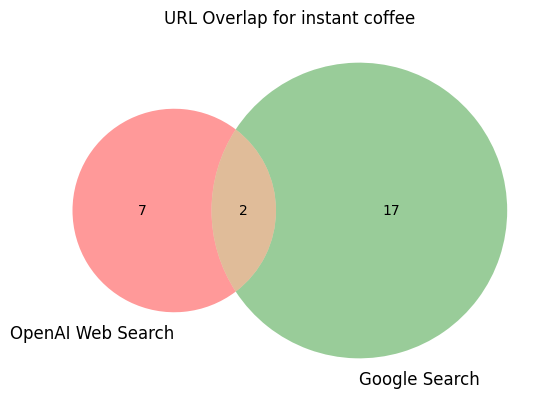

,Category,URLs in OpenAI Web Search,URLs in Google Search,Common URLs,Common URL List,Overlap Rate %
0,instant coffee,9,19,2,[https://cornercoffeestore.com/best-instant-co...,7.69


In [ ]:
compare_2_urls_by_category(
    OpenAI_data,
    serpapi_google_results,
    url_col1="urls",
    url_col2="Source",
    plot=True,
    venn_labels=('OpenAI Web Search', 'Google Search'),
    summary_labels=('URLs in OpenAI Web Search', 'URLs in Google Search')
)


📦 Category: instant coffee
✅ Common URLs (1):
    https://cornercoffeestore.com/best-instant-coffees-canada

🔴 Only in OpenAI Web Search (8):
                                                 urls
0   ['https://cornercoffeestore.com/best-instant-c...
4   ['https://cornercoffeestore.com/best-instant-c...
10  ['https://www.bestproductscanada.com/instant-b...
12  ['https://www.bestproductscanada.com/instant-c...
13  ['https://en.wikipedia.org/wiki/Nabob_%28coffe...
16     ['https://en.wikipedia.org/wiki/Nescaf%C3%A9']
17       ['https://en.wikipedia.org/wiki/Just_Us%21']
18          ['https://en.wikipedia.org/wiki/Folgers']
19  ['https://www.amazon.ca/Best-Sellers-Instant-C...

🔵 Only in Bing Search (3):
                                              Source
1  https://www.dropmocha.ca/post/top-7-instant-co...
2  https://www.dropmocha.ca/post/savoring-conveni...
3  https://www.narcity.com/instant-coffee-compari...


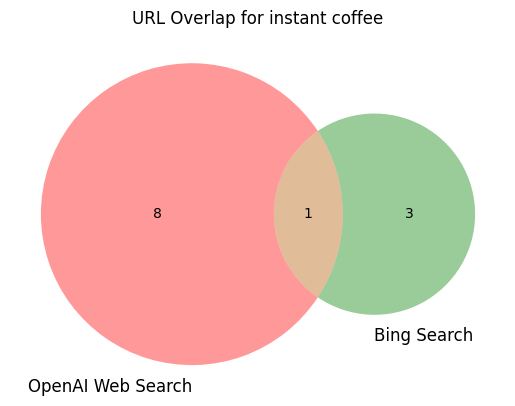

,Category,URLs in OpenAI Web Search,URLs in Bing Search,Common URLs,Common URL List,Overlap Rate %
0,instant coffee,9,4,1,[https://cornercoffeestore.com/best-instant-co...,8.33


In [ ]:
compare_2_urls_by_category(
    OpenAI_data,
    serpapi_bing_results,
    url_col1="urls",
    url_col2="Source",
    plot=True,
    venn_labels=('OpenAI Web Search', 'Bing Search'),
    summary_labels=('URLs in OpenAI Web Search', 'URLs in Bing Search')
)

In [ ]:
# bing_data = pd.read_csv("serpapi_bing_results.csv")

# compare_2_urls_by_category(
#     SonarPro_data,
#     serpapi_bing_results,
#     url_col1="urls",
#     url_col2="Source",
#     plot=True,
#     venn_labels=('SonarPro', 'Bing Search'),
#     summary_labels=('URLs in SonarPro', 'URLs in Bing')
# )

In [ ]:
# compare_2_urls_by_category(
#     SonarPro_data,
#     serpapi_google_results,
#     url_col1="urls",
#     url_col2="Source",
#     plot=True,
#     venn_labels=('SonarPro', 'Google Search'),
#     summary_labels=('URLs in SonarPro', 'URLs in Google Search')
# )

In [ ]:
# compare_2_urls_by_category(
#     SonarPro_data,
#     OpenAI_data,
#     url_col1="urls",
#     url_col2="urls",
#     plot=True,
#     venn_labels=('SonarPro', 'OpenAI Web Search'),
#     summary_labels=('URLs in SonarPro', 'URLs in OpenAI Web Search')
# )

### Precise comparison - OpenAI versus Google

In [ ]:
import pandas as pd
import ast
from datetime import datetime

def get_common_url_rows_with_overlap_type(
    openai_df: pd.DataFrame,
    serpapi_df: pd.DataFrame,
    openai_url_col: str = "urls",
    serpapi_url_col: str = "Source"
) -> pd.DataFrame:
    """
    Return a DataFrame containing only rows from openai_df and serpapi_df whose URLs overlap,
    plus a 'URL Overlap Type' column and the combined set of requested fields.
    """

    def normalize_url(url: str) -> str:
        return url.strip().rstrip("/").lower()

    def extract_urls(cell) -> list[str]:
        try:
            if isinstance(cell, str) and cell.startswith("["):
                lst = ast.literal_eval(cell)
            else:
                lst = [cell]
            return [normalize_url(u) for u in lst if isinstance(u, str)]
        except:
            return []

    # — explode OpenAI data —
    o = openai_df.copy()
    o["__norm_url"] = o[openai_url_col].apply(extract_urls)
    o = o.explode("__norm_url").rename(columns={openai_url_col: "orig_urls"})

    # — explode SERPAPI data —
    s = serpapi_df.copy()
    s["__norm_url"] = s[serpapi_url_col].apply(lambda u: [normalize_url(u)] if isinstance(u, str) else [])
    s = s.explode("__norm_url").rename(columns={serpapi_url_col: "orig_source"})

    # — inner join on normalized URL and category—
    # Assuming 'Category' column is in both DataFrames
    merged = pd.merge(
        o, s,
        on=["__norm_url", "Category"],  # Include 'Category' in the join condition
        how="inner",
        suffixes=("_openai", "_serpapi")
    )
    # Check if merged DataFrame is empty after the join
    if merged.empty:
        print("Warning: No common URLs and categories found between the two DataFrames.")
        return pd.DataFrame()  # Return an empty DataFrame if no common elements found

    # — classify overlap type —
    def classify(row) -> str:
        openai_set = set(extract_urls(row["orig_urls"]))
        serpapi_set = {normalize_url(row["orig_source"])}
        inter = openai_set & serpapi_set
        if not inter:
            return "No Match"
        if openai_set == serpapi_set:
            return "Exact Match"
        return "Partial Match"

    merged["URL Overlap Type"] = merged.apply(classify, axis=1)

    # — select & rename the requested columns —
    # Ensure all columns are present in the merged DataFrame before selection
    cols_to_select = [
        "brand", "short_title", "orig_urls", "Category", "URLs count", "Mention Count",
        "Avg Rank (Skip NaN)", "Avg Rank (Fill 0)", "Avg Rank (Fill 11)", "Query",
        "orig_source", "Source Rank", "Timestamp", "Search Source", "URL Overlap Type"
    ]
    # Only select columns that are present in the merged DataFrame
    available_cols = [col for col in cols_to_select if col in merged.columns]
    df_out = merged[available_cols].copy()

    df_out.rename(columns={
        "orig_urls": "urls",
        "orig_source": "Source link in Traditional Search",
        "Source Rank": "Source Rank in Traditional Search",
        "Timestamp": "Timestamp in Traditional Search"
    }, inplace=True)

    return df_out.reset_index(drop=True)

In [ ]:
OpenAI_Google_combined = get_common_url_rows_with_overlap_type(
    openai_df=OpenAI_data,
    serpapi_df=serpapi_google_results,
    openai_url_col="urls",
    serpapi_url_col="Source"
)
OpenAI_Google_combined.head()

,brand,short_title,urls,Category,URLs count,Mention Count,Avg Rank (Skip NaN),Avg Rank (Fill 0),Avg Rank (Fill 11),Query,Source link in Traditional Search,Source Rank in Traditional Search,Timestamp in Traditional Search,Search Source,URL Overlap Type
0,Tim Hortons,Tim Hortons Medium Roast Instant Coffee,['https://cornercoffeestore.com/best-instant-c...,instant coffee,2,79,1.00,0.77,3.25,Top recommended Instant Coffee in Canada,https://cornercoffeestore.com/best-instant-cof...,5,2025-04-24 17:19:03,Google Search,Partial Match
1,Maxwell House,Maxwell House Original Roast Instant Coffee,['https://cornercoffeestore.com/best-instant-c...,instant coffee,2,102,2.09,2.09,2.09,Top recommended Instant Coffee in Canada,https://cornercoffeestore.com/best-instant-cof...,5,2025-04-24 17:19:03,Google Search,Partial Match
2,Starbucks,Starbucks Via Instant True North Blend,['https://cornercoffeestore.com/best-instant-c...,instant coffee,2,79,3.00,2.32,4.80,Top recommended Instant Coffee in Canada,https://cornercoffeestore.com/best-instant-cof...,5,2025-04-24 17:19:03,Google Search,Partial Match
3,Nescafé,Nescafé Gold Espresso Instant Coffee,['https://cornercoffeestore.com/best-instant-c...,instant coffee,2,79,4.00,3.10,5.58,Top recommended Instant Coffee in Canada,https://cornercoffeestore.com/best-instant-cof...,5,2025-04-24 17:19:03,Google Search,Partial Match
4,Nescafé,Nescafé Rich Instant Coffee,['https://cornercoffeestore.com/best-instant-c...,instant coffee,2,79,5.00,3.87,6.35,Top recommended Instant Coffee in Canada,https://cornercoffeestore.com/best-instant-cof...,5,2025-04-24 17:19:03,Google Search,Partial Match


In [ ]:
OpenAI_Google_combined[(OpenAI_Google_combined['URL Overlap Type'] == 'Exact Match') | (OpenAI_Google_combined['URL Overlap Type'] == 'Partial Match')]

,brand,short_title,urls,Category,URLs count,Mention Count,Avg Rank (Skip NaN),Avg Rank (Fill 0),Avg Rank (Fill 11),Query,Source link in Traditional Search,Source Rank in Traditional Search,Timestamp in Traditional Search,Search Source,URL Overlap Type
0,Tim Hortons,Tim Hortons Medium Roast Instant Coffee,['https://cornercoffeestore.com/best-instant-c...,instant coffee,2,79,1.00,0.77,3.25,Top recommended Instant Coffee in Canada,https://cornercoffeestore.com/best-instant-cof...,5,2025-04-24 17:19:03,Google Search,Partial Match
1,Maxwell House,Maxwell House Original Roast Instant Coffee,['https://cornercoffeestore.com/best-instant-c...,instant coffee,2,102,2.09,2.09,2.09,Top recommended Instant Coffee in Canada,https://cornercoffeestore.com/best-instant-cof...,5,2025-04-24 17:19:03,Google Search,Partial Match
2,Starbucks,Starbucks Via Instant True North Blend,['https://cornercoffeestore.com/best-instant-c...,instant coffee,2,79,3.00,2.32,4.80,Top recommended Instant Coffee in Canada,https://cornercoffeestore.com/best-instant-cof...,5,2025-04-24 17:19:03,Google Search,Partial Match
3,Nescafé,Nescafé Gold Espresso Instant Coffee,['https://cornercoffeestore.com/best-instant-c...,instant coffee,2,79,4.00,3.10,5.58,Top recommended Instant Coffee in Canada,https://cornercoffeestore.com/best-instant-cof...,5,2025-04-24 17:19:03,Google Search,Partial Match
4,Nescafé,Nescafé Rich Instant Coffee,['https://cornercoffeestore.com/best-instant-c...,instant coffee,2,79,5.00,3.87,6.35,Top recommended Instant Coffee in Canada,https://cornercoffeestore.com/best-instant-cof...,5,2025-04-24 17:19:03,Google Search,Partial Match
5,Starbucks,Starbucks Medium Roast Premium Instant Coffee,['https://cornercoffeestore.com/best-instant-c...,instant coffee,2,79,6.00,4.65,7.13,Top recommended Instant Coffee in Canada,https://cornercoffeestore.com/best-instant-cof...,5,2025-04-24 17:19:03,Google Search,Partial Match
6,VitaCup,VitaCup Low Acid Instant Coffee,['https://cornercoffeestore.com/best-instant-c...,instant coffee,1,6,7.00,0.41,10.76,Top recommended Instant Coffee in Canada,https://cornercoffeestore.com/best-instant-cof...,5,2025-04-24 17:19:03,Google Search,Exact Match
7,Mount Hagen,Mount Hagen Organic Instant Coffee,['https://cornercoffeestore.com/best-instant-c...,instant coffee,1,15,8.00,1.18,10.56,Top recommended Instant Coffee in Canada,https://cornercoffeestore.com/best-instant-cof...,5,2025-04-24 17:19:03,Google Search,Exact Match
8,La Republica,La Republica Organic Decaf,['https://cornercoffeestore.com/best-instant-c...,instant coffee,1,5,9.00,0.44,10.90,Top recommended Instant Coffee in Canada,https://cornercoffeestore.com/best-instant-cof...,5,2025-04-24 17:19:03,Google Search,Exact Match
9,Alpine Start,Alpine Start Instant Coffee,['https://cornercoffeestore.com/best-instant-c...,instant coffee,1,5,10.00,0.49,10.95,Top recommended Instant Coffee in Canada,https://cornercoffeestore.com/best-instant-cof...,5,2025-04-24 17:19:03,Google Search,Exact Match


In [ ]:
# Manually add ranking of the product in the URL
OpenAI_Google_match = OpenAI_Google_combined[(OpenAI_Google_combined['URL Overlap Type'] == 'Exact Match') | (OpenAI_Google_combined['URL Overlap Type'] == 'Partial Match')]
OpenAI_Google_match_clean = OpenAI_Google_match.drop(columns=['Category','Avg Rank (Skip NaN)','Query','urls','Timestamp in Traditional Search','Search Source'])
OpenAI_Google_match_clean['Rank in common URL'] = [1,2,3,4,5,6,7,8,'Not Found','Not Found',10,9]
OpenAI_Google_match_clean.to_csv('OpenAI_Google_match_clean.csv', index=False)
OpenAI_Google_match_clean

,brand,short_title,URLs count,Mention Count,Avg Rank (Fill 0),Avg Rank (Fill 11),Source link in Traditional Search,Source Rank in Traditional Search,URL Overlap Type,Rank in common URL
0,Tim Hortons,Tim Hortons Medium Roast Instant Coffee,2,79,0.77,3.25,https://cornercoffeestore.com/best-instant-cof...,5,Partial Match,1
1,Maxwell House,Maxwell House Original Roast Instant Coffee,2,102,2.09,2.09,https://cornercoffeestore.com/best-instant-cof...,5,Partial Match,2
2,Starbucks,Starbucks Via Instant True North Blend,2,79,2.32,4.80,https://cornercoffeestore.com/best-instant-cof...,5,Partial Match,3
3,Nescafé,Nescafé Gold Espresso Instant Coffee,2,79,3.10,5.58,https://cornercoffeestore.com/best-instant-cof...,5,Partial Match,4
4,Nescafé,Nescafé Rich Instant Coffee,2,79,3.87,6.35,https://cornercoffeestore.com/best-instant-cof...,5,Partial Match,5
5,Starbucks,Starbucks Medium Roast Premium Instant Coffee,2,79,4.65,7.13,https://cornercoffeestore.com/best-instant-cof...,5,Partial Match,6
6,VitaCup,VitaCup Low Acid Instant Coffee,1,6,0.41,10.76,https://cornercoffeestore.com/best-instant-cof...,5,Exact Match,7
7,Mount Hagen,Mount Hagen Organic Instant Coffee,1,15,1.18,10.56,https://cornercoffeestore.com/best-instant-cof...,5,Exact Match,8
8,La Republica,La Republica Organic Decaf,1,5,0.44,10.90,https://cornercoffeestore.com/best-instant-cof...,5,Exact Match,Not Found
9,Alpine Start,Alpine Start Instant Coffee,1,5,0.49,10.95,https://cornercoffeestore.com/best-instant-cof...,5,Exact Match,Not Found


#### OpenAI versus Bing

In [ ]:
OpenAI_Bing_combined = get_common_url_rows_with_overlap_type(
    openai_df=OpenAI_data,
    serpapi_df=serpapi_bing_results,
    openai_url_col="urls",
    serpapi_url_col="Source"
)
OpenAI_Bing_combined.head()

,brand,short_title,urls,Category,URLs count,Mention Count,Avg Rank (Skip NaN),Avg Rank (Fill 0),Avg Rank (Fill 11),Query,Source link in Traditional Search,Source Rank in Traditional Search,Timestamp in Traditional Search,Search Source,URL Overlap Type
0,Tim Hortons,Tim Hortons Medium Roast Instant Coffee,['https://cornercoffeestore.com/best-instant-c...,instant coffee,2,79,1.00,0.77,3.25,Top recommended Instant Coffee in Canada,https://cornercoffeestore.com/best-instant-cof...,1,2025-04-24 17:19:06,Bing Search,Partial Match
1,Maxwell House,Maxwell House Original Roast Instant Coffee,['https://cornercoffeestore.com/best-instant-c...,instant coffee,2,102,2.09,2.09,2.09,Top recommended Instant Coffee in Canada,https://cornercoffeestore.com/best-instant-cof...,1,2025-04-24 17:19:06,Bing Search,Partial Match
2,Starbucks,Starbucks Via Instant True North Blend,['https://cornercoffeestore.com/best-instant-c...,instant coffee,2,79,3.00,2.32,4.80,Top recommended Instant Coffee in Canada,https://cornercoffeestore.com/best-instant-cof...,1,2025-04-24 17:19:06,Bing Search,Partial Match
3,Nescafé,Nescafé Gold Espresso Instant Coffee,['https://cornercoffeestore.com/best-instant-c...,instant coffee,2,79,4.00,3.10,5.58,Top recommended Instant Coffee in Canada,https://cornercoffeestore.com/best-instant-cof...,1,2025-04-24 17:19:06,Bing Search,Partial Match
4,Nescafé,Nescafé Rich Instant Coffee,['https://cornercoffeestore.com/best-instant-c...,instant coffee,2,79,5.00,3.87,6.35,Top recommended Instant Coffee in Canada,https://cornercoffeestore.com/best-instant-cof...,1,2025-04-24 17:19:06,Bing Search,Partial Match


In [ ]:
# Manually add ranking of the product in the URL
OpenAI_Bing_match = OpenAI_Bing_combined[(OpenAI_Bing_combined['URL Overlap Type'] == 'Exact Match') | (OpenAI_Bing_combined['URL Overlap Type'] == 'Partial Match')]
OpenAI_Bing_match_clean = OpenAI_Bing_match.drop(columns=['Category','Avg Rank (Skip NaN)','Query','urls','Timestamp in Traditional Search','Search Source'])
OpenAI_Bing_match_clean.to_csv('OpenAI_Bing_match_clean.csv', index=False)
OpenAI_Bing_match_clean

,brand,short_title,URLs count,Mention Count,Avg Rank (Fill 0),Avg Rank (Fill 11),Source link in Traditional Search,Source Rank in Traditional Search,URL Overlap Type
0,Tim Hortons,Tim Hortons Medium Roast Instant Coffee,2,79,0.77,3.25,https://cornercoffeestore.com/best-instant-cof...,1,Partial Match
1,Maxwell House,Maxwell House Original Roast Instant Coffee,2,102,2.09,2.09,https://cornercoffeestore.com/best-instant-cof...,1,Partial Match
2,Starbucks,Starbucks Via Instant True North Blend,2,79,2.32,4.80,https://cornercoffeestore.com/best-instant-cof...,1,Partial Match
3,Nescafé,Nescafé Gold Espresso Instant Coffee,2,79,3.10,5.58,https://cornercoffeestore.com/best-instant-cof...,1,Partial Match
4,Nescafé,Nescafé Rich Instant Coffee,2,79,3.87,6.35,https://cornercoffeestore.com/best-instant-cof...,1,Partial Match
5,Starbucks,Starbucks Medium Roast Premium Instant Coffee,2,79,4.65,7.13,https://cornercoffeestore.com/best-instant-cof...,1,Partial Match
6,VitaCup,VitaCup Low Acid Instant Coffee,1,6,0.41,10.76,https://cornercoffeestore.com/best-instant-cof...,1,Exact Match
7,Mount Hagen,Mount Hagen Organic Instant Coffee,1,15,1.18,10.56,https://cornercoffeestore.com/best-instant-cof...,1,Exact Match
8,La Republica,La Republica Organic Decaf,1,5,0.44,10.90,https://cornercoffeestore.com/best-instant-cof...,1,Exact Match
9,Alpine Start,Alpine Start Instant Coffee,1,5,0.49,10.95,https://cornercoffeestore.com/best-instant-cof...,1,Exact Match
